In [2]:
import os
import json
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score, accuracy_score

In [3]:
train_df = pd.read_csv("../data/train.csv", header=None, index_col=None, sep="\t", names=["label", "text"])
dev_df = pd.read_csv("../data/dev.csv", header=None, index_col=None, sep="\t", names=["label", "text"])
train_df.head(3)

,label,text
0,news_edu,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？
1,news_finance,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告
2,news_house,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？


In [4]:
with open("../data/label.json", "r", encoding="utf-8") as f:
    label_dict = json.load(f)
label2id = dict((k, v["label_id"]) for k, v in label_dict.items())
label2id

{'news_story': 0,
 'news_culture': 1,
 'news_entertainment': 2,
 'news_sports': 3,
 'news_finance': 4,
 'news_house': 5,
 'news_car': 6,
 'news_edu': 7,
 'news_tech': 8,
 'news_military': 9,
 'news_travel': 10,
 'news_world': 11,
 'news_stock': 12,
 'news_agriculture': 13,
 'news_game': 14}

In [5]:
train_df["label_id"] = train_df["label"].map(label2id)
dev_df["label_id"] = dev_df["label"].map(label2id)
train_df.head(3)

,label,text,label_id
0,news_edu,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？,7
1,news_finance,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告,4
2,news_house,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？,5


In [6]:
tfidf = TfidfVectorizer(analyzer="char", ngram_range=(1, 3), max_features=10000)

In [7]:
train_data = tfidf.fit_transform(train_df["text"].tolist() + dev_df["text"].tolist())

In [11]:
train_data

<63360x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1974804 stored elements in Compressed Sparse Row format>

In [8]:
tfidf.get_feature_names_out()[:100]

array([' ', ' 1', ' 2', ' 20', ' 3', ' 4', ' 5', ' a', ' b', ' c', ' f',
       ' g', ' i', ' m', ' o', ' p', ' r', ' s', ' t', ' v', ' x', ' “',
       ' 一', ' 上', ' 不', ' 中', ' 中国', ' 为', ' 但', ' 你', ' 全', ' 净', ' 净赚',
       ' 国', ' 大', ' 将', ' 小', ' 我', ' 打', ' 新', ' 最', ' 有', ' 看', ' 网',
       ' 网友', ' 美', ' 让', ' 还', ' 这', ' 高', '!', '"', '%', '% ', '%的',
       '%，', '&', '(', ')', '+', '+1', ',', ', ', '-', '-0', '-1', '-2',
       '-20', '-3', '-4', '.', '.0', '.0t', '.1', '.12', '.2', '.3', '.4',
       '.5', '.5亿', '.6', '.7', '.8', '.9', '/', '0', '0 ', '0%', '0%，',
       '0-', '0.', '00', '00%', '000', '00万', '00个', '00人', '00亿', '00元',
       '00公'], dtype=object)

In [18]:
clf = RidgeClassifier()
clf.fit(train_data[:len(train_df)], train_df["label_id"])

RidgeClassifier()

In [19]:
pred = clf.predict(train_data[len(train_df):])
print(f1_score(dev_df["label_id"], pred, average="macro"))
print(f1_score(dev_df["label_id"], pred, average="micro"))
print(accuracy_score(dev_df["label_id"], pred))

0.5134519879158675
0.5417
0.5417


[[ 74  21  42   6   2   7   3  12   7   1   5  15   0  18   2]
 [  7 356  84  19  23   3  12  59  18  23  66  32   0  26   8]
 [ 21  61 559  48  26   5  19  24  32  14  20  42   0  10  29]
 [  1  14  84 530  18   4  25  13  19  12  10  14   0   4  19]
 [  1  15  24  10 452  38  28  23 225  15  23  56   0  38   8]
 [  1   3  10   2  48 219  14  10  21   3  22   7   1  16   1]
 [  0  20  35  11  34   8 502  14  72  18  26  28   0  10  13]
 [  5  31  41  21  18   9  11 399  34  12  25  15   0  17   8]
 [  0  20  25  14 205  15  64  53 564  25   9  26   1  15  53]
 [  5  18  37   7  13   1  19  21  28 358  13 176   0   2  18]
 [  4  66  41  12  30  19  41  17  26  13 315  57   0  47   5]
 [  4  30  56  20  47  13  17  18  31 137  45 455   0  19  13]
 [  0   0   0   0  33   0   0   0   8   0   1   0   3   0   0]
 [  7  27  14   4  50  18  17  15  29   5  44  22   0 242   0]
 [  1  20  67  40  11   1  14  14  45  30  13   6   0   8 389]]


<AxesSubplot:>

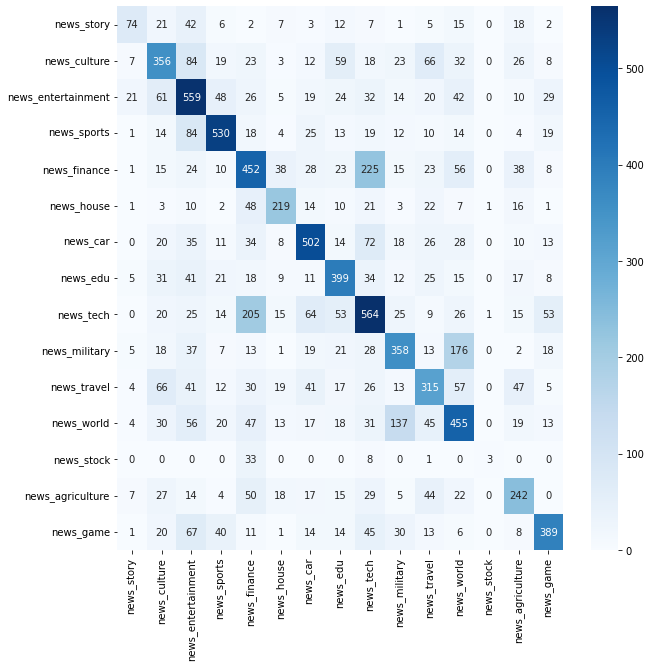

In [34]:
# 打印出混淆矩阵
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

cm = confusion_matrix(dev_df["label_id"], pred, labels=list(label2id.values()))
print(cm)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.keys(), yticklabels=label_dict.keys())

In [32]:
total = cm.sum(axis=1)
total

array([ 215,  736,  910,  767,  956,  378,  791,  646, 1089,  716,  693,
        905,   45,  494,  659], dtype=int64)

[[0.34418605 0.09767442 0.19534884 0.02790698 0.00930233 0.03255814
  0.01395349 0.05581395 0.03255814 0.00465116 0.02325581 0.06976744
  0.         0.08372093 0.00930233]
 [0.00951087 0.48369565 0.11413043 0.02581522 0.03125    0.00407609
  0.01630435 0.08016304 0.02445652 0.03125    0.08967391 0.04347826
  0.         0.03532609 0.01086957]
 [0.02307692 0.06703297 0.61428571 0.05274725 0.02857143 0.00549451
  0.02087912 0.02637363 0.03516484 0.01538462 0.02197802 0.04615385
  0.         0.01098901 0.03186813]
 [0.00130378 0.01825293 0.1095176  0.69100391 0.02346806 0.00521512
  0.03259452 0.01694915 0.02477184 0.01564537 0.01303781 0.01825293
  0.         0.00521512 0.02477184]
 [0.00104603 0.01569038 0.0251046  0.01046025 0.47280335 0.03974895
  0.0292887  0.02405858 0.23535565 0.01569038 0.02405858 0.05857741
  0.         0.03974895 0.0083682 ]
 [0.0026455  0.00793651 0.02645503 0.00529101 0.12698413 0.57936508
  0.03703704 0.02645503 0.05555556 0.00793651 0.05820106 0.01851852
  0.

<AxesSubplot:>

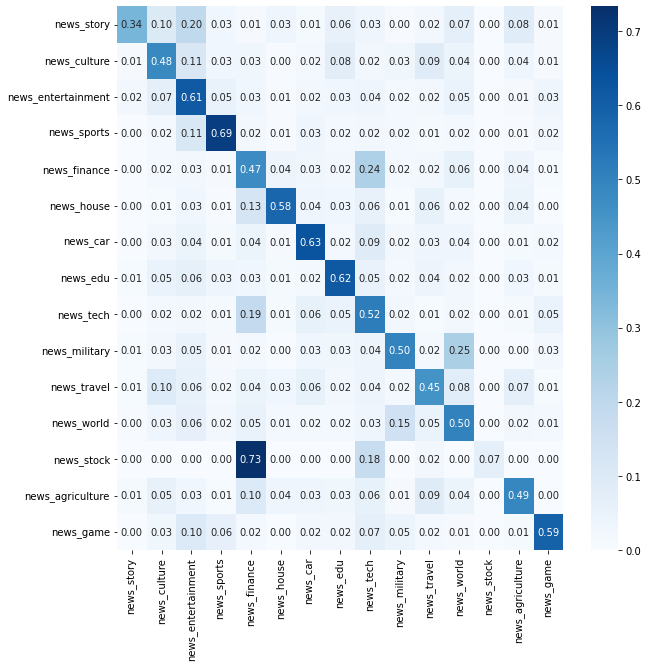

In [33]:
# 用百分比表示
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
print(cm_percent)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_dict.keys(), yticklabels=label_dict.keys())

In [38]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_data[:len(train_df)].toarray(), train_df["label_id"])

pred = clf.predict(train_data[len(train_df):].toarray())
print(f1_score(dev_df["label_id"], pred, average="macro"))
print(f1_score(dev_df["label_id"], pred, average="micro"))
print(accuracy_score(dev_df["label_id"], pred))

0.3243258005282795
0.3462
0.3462


In [39]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(train_data[:len(train_df)].toarray(), train_df["label_id"])

pred = clf.predict(train_data[len(train_df):].toarray())
print(f1_score(dev_df["label_id"], pred, average="macro"))
print(f1_score(dev_df["label_id"], pred, average="micro"))
print(accuracy_score(dev_df["label_id"], pred))

0.3925864283378347
0.4094
0.4094


In [40]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_data[:len(train_df)].toarray(), train_df["label_id"])

pred = clf.predict(train_data[len(train_df):].toarray())
print(f1_score(dev_df["label_id"], pred, average="macro"))
print(f1_score(dev_df["label_id"], pred, average="micro"))
print(accuracy_score(dev_df["label_id"], pred))

0.4947529441768913
0.528
0.528


In [42]:
# 这个真不行, 跑的太慢了
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(train_data[:len(train_df)].toarray(), train_df["label_id"])

pred = clf.predict(train_data[len(train_df):].toarray())
print(f1_score(dev_df["label_id"], pred, average="macro"))
print(f1_score(dev_df["label_id"], pred, average="micro"))
print(accuracy_score(dev_df["label_id"], pred))

0.5071336165390682
0.5223
0.5223


In [12]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(train_data[:len(train_df)].toarray(), train_df["label_id"])

pred = clf.predict(train_data[len(train_df):].toarray())
print(f1_score(dev_df["label_id"], pred, average="macro"))
print(f1_score(dev_df["label_id"], pred, average="micro"))
print(accuracy_score(dev_df["label_id"], pred))

0.5236240034073153
0.5395
0.5395
